# Automatic Liver Lesion Segmentation using Keras (Tensorflow as backend) realtime training

#### Module required for training

In [1]:
import scipy as sp
import scipy.misc, scipy.ndimage.interpolation
from medpy import metric
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D,Dropout,Conv2DTranspose
from keras.layers.normalization import BatchNormalization as bn
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers 
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


#### Helper Methods
- Method read_dicom_series read dicom series images and returns a NumPy Array
- Method read_liver_lesion_masks read liver lesion masks and returns NumPy Array

In [2]:
import dicom
import natsort
import glob, os
import re
def read_dicom_series(directory, filepattern = "image_*"):
    """ Reads a DICOM Series files in the given directory. 
    Only filesnames matching filepattern will be considered"""
    
    if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
    print '\tRead Dicom',directory
    lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
    print '\tLength dicom series',len(lstFilesDCM)
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

    return ArrayDicom

def read_liver_lesion_masks(masks_dirname):
    """Since 3DIRCAD provides an individual mask for each tissue type (in DICOM series format),
    we merge multiple tissue types into one Tumor mask, and merge this mask with the liver mask
    
    Args:
        masks_dirname : MASKS_DICOM directory containing multiple DICOM series directories, 
                        one for each labelled mask
    Returns:
        numpy array with 0's for background pixels, 1's for liver pixels and 2's for tumor pixels
    """
    tumor_volume = None
    liver_volume = None
    
    # For each relevant organ in the current volume
    for organ in os.listdir(masks_dirname):
        organ_path = os.path.join(masks_dirname,organ)
        if not os.path.isdir(organ_path):
            continue
        
        organ = organ.lower()
        
        if organ.startswith("livertumor") or re.match("liver.yst.*", organ) or organ.startswith("stone") or organ.startswith("metastasecto") :
            print 'Organ',masks_dirname,organ
            current_tumor = read_dicom_series(organ_path)
            current_tumor = np.clip(current_tumor,0,1)
            # Merge different tumor masks into a single mask volume
            tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
        elif organ == 'liver':
            print 'Organ',masks_dirname,organ
            liver_volume = read_dicom_series(organ_path)
            liver_volume = np.clip(liver_volume, 0, 1)
    
    # Merge liver and tumor into 1 volume with background=0, liver=1, tumor=2
    label_volume = np.zeros(liver_volume.shape)
    label_volume[liver_volume==1]=1
    label_volume[tumor_volume==1]=2
    return label_volume

#### Method for UNET model metric and loss function
Dice Coffecient is a statistic used for comparing the similarity of two samples.

In [3]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [4]:
from matplotlib import pyplot as plt
from IPython import display
plt.set_cmap('gray')
%matplotlib inline
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

#### Method for pre-processing the 3DIRCAD1 Datatset
- Dataset has 20 CT volumes
- Each volume's slc is pre-processed by normalizing Hounsfield unit
- 2074 slices are obtained which container liver in the slices

In [89]:

def norm_hounsfield_dyn(arr, c_min=0.1, c_max=0.3):
    """ Converts from hounsfield units to float64 image with range 0.0 to 1.0 """
    # calc min and max
    min,max = np.amin(arr), np.amax(arr)
    arr = arr.astype(IMG_DTYPE)
    if min <= 0:
        arr = np.clip(arr, min * c_min, max * c_max)
        # right shift to zero
        arr = np.abs(min * c_min) + arr
    else:
        arr = np.clip(arr, min, max * c_max)
        # left shift to zero
        arr = arr - min
    # normalization
    norm_fac = np.amax(arr)
    if norm_fac != 0:
        #norm = (arr*255)/ norm_fac
        norm = np.divide(
                np.multiply(arr,255),
                np.amax(arr))
    else:  # don't divide through 0
        norm = np.multiply(arr, 255)

    norm = np.clip(np.multiply(norm, 0.00390625), 0, 1)
    return norm

In [5]:
def find_liver_slice(datavol,segvol):
    """
    for training purpose we will use only train on slices that have the liver
    segmentation 
    
    """
    ind_liver = (np.sum(segvol,axis=(0,1)) != 0)
    datavol = datavol[:,:,ind_liver]
    segvol = segvol[:,:,ind_liver]
    return datavol,segvol

In [27]:
DATASET_DIR="/home/dhara/AdvBioMed/Dataset/3Dircadb1/"
IMAGE_DIR="/home/dhara/AdvBioMed/Dataset/images/"
SEG_DIR="/home/dhara/AdvBioMed/Dataset/segmentation/"

In [33]:
def save_slc_np(volume,prefix):
    for i in range(volume.shape[2]):
        img=volume[:,:,i]
        filename=prefix+'_slice_'+str(i)
        np.save(filename,img)

In [34]:
def dicom_to_npy(volid,patient_dir):
    image_folder=patient_dir+"/PATIENT_DICOM"
    seg_folder=patient_dir+"/MASKS_DICOM"
    imgvol=read_dicom_series(image_folder)
    lblvol=read_liver_lesion_masks(seg_folder)
    print imgvol.shape,lblvol.shape
    imgvol,lblvol=find_liver_slice(imgvol,lblvol)
    print imgvol.shape,lblvol.shape
    prefix=IMAGE_DIR+"vol"+str(volid)
    save_slc_np(imgvol,prefix)
    prefix=SEG_DIR+"seg"+str(volid)
    save_slc_np(lblvol,prefix)
    
 

In [36]:
for i in range(1,21):
    dicom_to_npy(i,DATASET_DIR+"3Dircadb1."+str(i))

	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/PATIENT_DICOM
	Length dicom series 129
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor06
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor06
	Length dicom series 129
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor04
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor04
	Length dicom series 129
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor01
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor01
	Length dicom series 129
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor05
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor05
	Length dicom series 129
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor02
	Read Dicom /home/dhara/Ad

Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.13/MASKS_DICOM liver
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.13/MASKS_DICOM/liver
	Length dicom series 122
(512, 512, 122) (512, 512, 122)
(512, 512, 90) (512, 512, 90)
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.14/PATIENT_DICOM
	Length dicom series 113
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.14/MASKS_DICOM liver
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.14/MASKS_DICOM/liver
	Length dicom series 113
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.14/MASKS_DICOM metastasectomie
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.14/MASKS_DICOM/metastasectomie
	Length dicom series 113
(512, 512, 113) (512, 512, 113)
(512, 512, 104) (512, 512, 104)
	Read Dicom /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.15/PATIENT_DICOM
	Length dicom series 125
Organ /home/dhara/AdvBioMed/Dataset/3Dircadb1/3Dircadb1.15/MASKS_DICOM livertumor
	Read Dic

In [52]:
import os
import glob,natsort
IRCA_IMG="/home/dhara/AdvBioMed/Dataset/images/"
IRCA_SEG="/home/dhara/AdvBioMed/Dataset/masks/"

image_file = natsort.natsorted(glob.glob(os.path.join("/home/dhara/AdvBioMed/Dataset/irca_img/", 'img*.npy')))
seg_file = natsort.natsorted(glob.glob(os.path.join("/home/dhara/AdvBioMed/Dataset/irca_seg/", 'seg*.npy')))
for i in range(len(image_file)):
    print image_file[i],seg_file[i]
    img=np.load(image_file[i])
    np.save(IRCA_IMG+str(i+1),img)
    seg=np.load(seg_file[i])
    np.save(IRCA_SEG+str(i+1),seg)


/home/dhara/AdvBioMed/Dataset/irca_img/img_1.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_3.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_3.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_4.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_4.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_5.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_5.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_6.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_6.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_7.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_7.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_8.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_8.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_9.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_9.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_10.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_10.npy
/home/dhara/AdvBio

/home/dhara/AdvBioMed/Dataset/irca_img/img_130.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_130.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_131.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_131.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_132.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_132.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_133.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_133.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_134.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_134.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_135.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_135.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_136.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_136.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_137.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_137.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_138.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_138.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_139.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_263.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_263.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_264.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_264.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_265.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_265.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_266.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_266.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_267.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_267.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_268.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_268.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_269.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_269.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_270.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_270.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_271.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_271.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_272.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_401.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_401.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_402.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_402.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_403.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_403.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_404.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_404.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_405.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_405.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_406.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_406.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_407.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_407.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_408.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_408.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_409.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_409.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_410.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_539.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_539.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_540.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_540.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_541.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_541.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_542.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_542.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_543.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_543.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_544.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_544.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_545.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_545.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_546.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_546.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_547.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_547.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_548.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_677.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_677.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_678.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_678.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_679.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_679.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_680.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_680.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_681.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_681.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_682.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_682.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_683.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_683.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_684.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_684.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_685.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_685.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_686.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_816.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_816.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_817.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_817.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_818.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_818.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_819.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_819.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_820.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_820.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_821.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_821.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_822.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_822.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_823.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_823.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_824.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_824.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_825.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_956.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_956.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_957.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_957.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_958.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_958.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_959.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_959.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_960.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_960.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_961.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_961.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_962.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_962.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_963.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_963.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_964.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_964.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_965.npy /home/dhara/AdvBioMed/Dataset/i

/home/dhara/AdvBioMed/Dataset/irca_img/img_1096.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1096.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1097.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1097.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1098.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1098.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1099.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1099.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1100.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1100.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1101.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1101.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1102.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1102.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1103.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1103.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1104.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1104.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1105.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_1236.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1236.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1237.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1237.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1238.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1238.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1239.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1239.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1240.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1240.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1241.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1241.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1242.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1242.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1243.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1243.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1244.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1244.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1245.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_1376.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1376.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1377.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1377.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1378.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1378.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1379.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1379.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1380.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1380.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1381.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1381.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1382.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1382.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1383.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1383.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1384.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1384.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1385.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_1516.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1516.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1517.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1517.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1518.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1518.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1519.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1519.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1520.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1520.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1521.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1521.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1522.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1522.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1523.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1523.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1524.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1524.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1525.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_1656.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1656.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1657.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1657.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1658.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1658.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1659.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1659.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1660.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1660.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1661.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1661.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1662.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1662.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1663.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1663.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1664.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1664.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1665.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_1793.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1793.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1794.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1794.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1795.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1795.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1796.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1796.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1797.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1797.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1798.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1798.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1799.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1799.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1800.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1800.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1801.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1801.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1802.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_1927.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1927.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1928.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1928.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1929.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1929.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1930.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1930.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1931.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1931.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1932.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1932.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1933.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1933.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1934.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1934.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1935.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_1935.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_1936.npy /home/dhara/

/home/dhara/AdvBioMed/Dataset/irca_img/img_2061.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2061.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2062.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2062.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2063.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2063.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2064.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2064.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2065.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2065.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2066.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2066.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2067.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2067.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2068.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2068.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2069.npy /home/dhara/AdvBioMed/Dataset/irca_seg/seg_2069.npy
/home/dhara/AdvBioMed/Dataset/irca_img/img_2070.npy /home/dhara/

In [77]:

train = []
image_file = natsort.natsorted(glob.glob(os.path.join("/home/dhara/AdvBioMed/Dataset/images/", '*.npy')))
for i in range(len(image_file)):
    name=os.path.basename(IRCA_IMG+str(i+1)+".npy")
    base=os.path.splitext(name)[0]
    train.append(base)
print len(train)
thefile = open('train.txt', 'w')
for item in train[:1504]:
    thefile.write(item+'\n')
thefile.close()
thefile = open('val.txt', 'w')
for item in train[1504:]:
    thefile.write(item+'\n')
thefile.close()

2074


### UNET Architecture
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="Drawing" style="width: 800px;height:600px"/>

Credit:https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [63]:
def UNet(input_shape,learn_rate=1e-3):
    l2_lambda = 0.0002
    DropP = 0.3
    kernel_size=3

    inputs = Input(input_shape)

    conv1 = Conv2D( 32, (kernel_size, kernel_size), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
    
    
    conv1 = bn()(conv1)
    
    conv1 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)

    conv1 = bn()(conv1)
    
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    pool1 = Dropout(DropP)(pool1)





    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
    
    conv2 = bn()(conv2)

    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)

    conv2 = bn()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    pool2 = Dropout(DropP)(pool2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)

    conv3 = bn()(conv3)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
    
    conv3 = bn()(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    pool3 = Dropout(DropP)(pool3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(pool3)
    conv4 = bn()(conv4)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
    
    conv4 = bn()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    pool4 = Dropout(DropP)(pool4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
    
    conv5 = bn()(conv5)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)

    conv5 = bn()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)

    up6 = Dropout(DropP)(up6)


    conv6 = Conv2D(256,(3, 3), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
    
    conv6 = bn()(conv6)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

    conv6 = bn()(conv6)

    up7 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)

    up7 = Dropout(DropP)(up7)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(up7)

    conv7 = bn()(conv7)
    
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)

    conv7 = bn()(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)

    up8 = Dropout(DropP)(up8)

    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', 
                   kernel_regularizer=regularizers.l2(l2_lambda) )(up8)

    conv8 = bn()(conv8)

    
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)

    conv8 = bn()(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)

    up9 = Dropout(DropP)(up9)

    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
    
    conv9 = bn()(conv9)

    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
   
    conv9 = bn()(conv9)
   
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return model


In [64]:
model=UNet(input_shape=(512,512,1))
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 512, 512, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 512, 512, 32) 128         conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 512, 512, 32) 9248        batch_normalization_91[0][0]     
__________________________________________________________________________________________________
batch_norm

In [15]:
import glob
train_file_path="/home/dhara/AdvBioMed/train.txt"
data_dir="/home/dhara/AdvBioMed/Dataset/images/"
data_suffix="npy"
label_dir="/home/dhara/AdvBioMed/Dataset/masks/"
label_suffix="npy"
batch_size="16"

In [16]:
fnames = glob.glob(data_dir+'*.npy')
lnames=  glob.glob(label_dir+'*.npy')

In [17]:
def open_image(fn): return np.load(fn)

In [18]:
imgs = np.stack([open_image(fn) for fn in fnames])
imgs_gray=np.expand_dims(imgs,axis=3)
print imgs_gray.shape

(2074, 512, 512, 1)


In [19]:
labels = np.stack([open_image(fn) for fn in lnames])
labels_gray=np.expand_dims(labels,axis=3)
print labels_gray.shape

(2074, 512, 512, 1)


In [20]:
imgs_gray.shape,labels_gray.shape

((2074, 512, 512, 1), (2074, 512, 512, 1))

In [9]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [7]:
def load_array(fname): return bcolz.open(fname)[:]

In [23]:
PATH="/home/dhara/AdvBioMed/Dataset/"
save_array(PATH+'imgs.bc', imgs_gray)
save_array(PATH+'labels.bc', labels_gray)

In [10]:
PATH="/home/dhara/AdvBioMed/Dataset/"
imgs = load_array(PATH+'imgs.bc')
labels = load_array(PATH+'labels.bc')

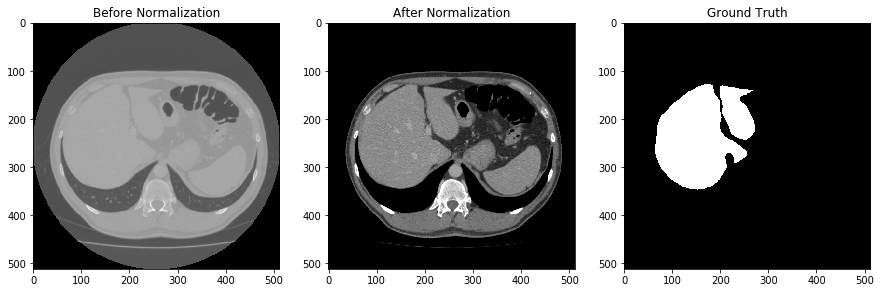

In [14]:
IMG_DTYPE = np.float
SEG_DTYPE = np.uint8
for i in range (imgs.shape[0]):
    img=imgs[i,...]
    label=labels[i,...]
    img=np.reshape(img,(512,512))
    label=np.reshape(label,(512,512))
    temp=norm_hounsfield_dyn(img)
    imshow(img,temp,label,title=['Before Normalization','After Normalization','Ground Truth'])
    break

In [17]:
def apply_normalization(imgs):
    imgs_norm=np.zeros((imgs.shape[0],512,512))
    for i in range (imgs_norm.shape[0]): 
        img=imgs[i,...]
        img=np.reshape(img,(512,512))
        temp=norm_hounsfield_dyn(img)
        imgs_norm[i:,:]=temp
    return imgs_norm


In [18]:
imgs_norm=apply_normalization(imgs=imgs)
    

In [19]:
save_array(PATH+'imgs_norm.bc', imgs_norm)

In [20]:
imgs_norm=load_array(PATH+"imgs_norm.bc")

In [21]:
#imgs_final=np.expand_dims(imgs_norm,axis=3)
#imgs_temp=imgs_norm.copy()
imgs_final=imgs_norm.reshape(imgs_norm.shape[0],512,512,1)
print imgs_final.shape

(2074, 512, 512, 1)


In [22]:
n,r,c,ch = imgs_final.shape
print n,r,c,ch

2074 512 512 1


### Batch Geneartor Code
- Below methods are used to generate the slices and corresponding label in slices

In [25]:
import threading
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def next(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [26]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [27]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([8, 1, 4]),
 array([3, 9, 7]),
 array([0, 5, 2]),
 array([6]),
 array([4, 5, 6])]

In [49]:
import random
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(512,512), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def next(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys)

(4, 512, 512, 1)


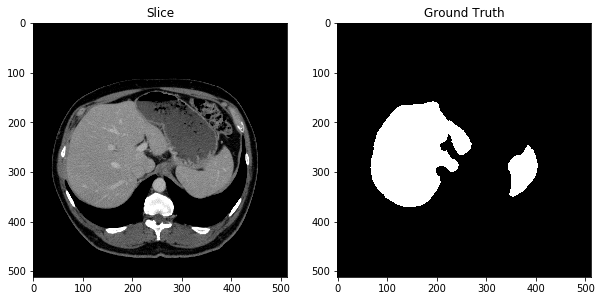

In [54]:
sg = segm_generator(imgs_final, labels, 4, train=False)
b_img, b_label = next(sg)
print b_label.shape
imshow(b_img[1].reshape(512,512),b_label[1].reshape(512,512),title=['Slice','Ground Truth']);

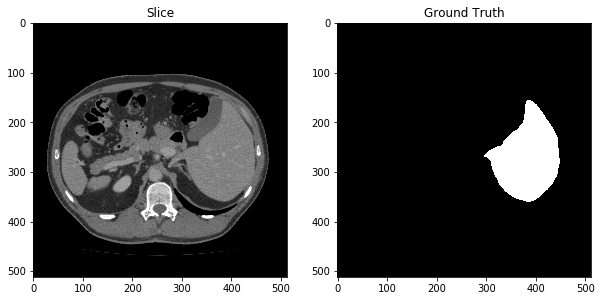

In [51]:
sg = segm_generator(imgs_final, labels, 4, train=True)
b_img, b_label = next(sg)
imshow(b_img[1].reshape(512,512),b_label[1].reshape(512,512),title=['Slice','Ground Truth']);

In [52]:
train_images=imgs_final[:1500,:,:]
train_label=labels[:1500,:,:]
print train_images.shape,train_label.shape

(1500, 512, 512, 1) (1500, 512, 512, 1)


In [55]:
validation_images=imgs_final[1500:,:,:]
validation_labels=labels[1500:,:,:]
print validation_images.shape,validation_labels.shape

(574, 512, 512, 1) (574, 512, 512, 1)


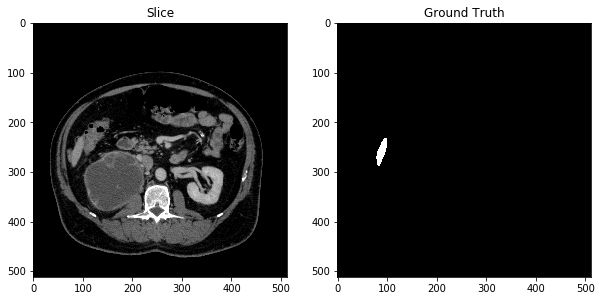

In [56]:
sg = segm_generator(train_images, train_label, 4, train=True)
b_img, b_label = next(sg)
imshow(b_img[1].reshape(512,512),b_label[1].reshape(512,512),title=['Slice','Ground Truth']);

In [57]:
# For Python 2 compatibility

def seg_gen(x, y, bs=64, out_sz=(512,512), train=True):
    """
    Generator wrapper on iterators for python 2 compatibility.
    """
    sg = segm_generator(x=x, y=y, bs=bs, out_sz = out_sz ,train=train)
    while True:
        yield sg.next()

In [58]:
gen = seg_gen(train_images, train_label, bs=4, train=True)

X, y = next(gen)
print X.shape

(4, 512, 512, 1)


#### Helper method to generate train and testing/validation slices

In [59]:
def create_train_generator(imgs,labels,bs=2):
    return seg_gen(imgs, labels, bs=bs, train=True)

In [60]:
def create_test_generator(imgs,labels,bs=2):
    return seg_gen(imgs, labels, bs=2, train=False)

### Method for Training
- Below method save the model and train for the requested epochs
- One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
- Batch Size:Total number of training examples present in a single batch
- Steps_Per_Epoch:Total number of steps (batches of samples) before declaring one epoch finished and starting 
  the next epoch


In [67]:
import datetime
from time import time
def train_and_evaluate_model(model,gen_train,gen_test,ckpt_dir,log_dir,epochs=100):
    
    z = datetime.datetime.now().strftime ("%Y%m%d")
    print z
    ckpt_file_name = ckpt_dir +"/"+"train"+".hdf5"
    checkpoint = ModelCheckpoint(ckpt_file_name, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
    tensorboard = TensorBoard(log_dir=log_dir+"/{}".format(time()))
    callbacks_list = [checkpoint,tensorboard]
    model.fit_generator(gen_train,steps_per_epoch=100,verbose=2,epochs=epochs, validation_data=gen_test, 
                        validation_steps=30,
                        callbacks=callbacks_list)
    return model

In [68]:
gen_train = create_train_generator(train_images,train_label)
gen_test = create_test_generator(validation_images,validation_labels)
ckpt_dir = "/home/dhara/AdvBioMed/model"
log_dir = "/home/dhara/AdvBioMed/logs"
model=UNet(input_shape=(512,512,1))
train_and_evaluate_model(model,gen_train, gen_test, ckpt_dir,log_dir)

20171115
Epoch 1/100
Epoch 00001: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 36s - loss: 0.3160 - dice_coef: 0.2213 - val_loss: 0.4068 - val_dice_coef: 0.1158
Epoch 2/100
Epoch 00002: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: 0.2741 - dice_coef: 0.2337 - val_loss: 0.3517 - val_dice_coef: 0.1407
Epoch 3/100
Epoch 00003: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: 0.2038 - dice_coef: 0.2738 - val_loss: 0.2819 - val_dice_coef: 0.1806
Epoch 4/100
Epoch 00004: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: 0.1520 - dice_coef: 0.2961 - val_loss: 0.2141 - val_dice_coef: 0.2196
Epoch 5/100
Epoch 00005: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: 0.0872 - dice_coef: 0.3329 - val_loss: 0.1081 - val_dice_coef: 0.2986
Epoch 6/100
Epoch 00006: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: 0.0538 - dice_coef: 0.3405 - val_loss: 0.1091 - val_dice_coef: 0.2732
E

Epoch 00048: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -4.0462e-01 - dice_coef: 0.6395 - val_loss: -1.7757e-01 - val_dice_coef: 0.4119
Epoch 49/100
Epoch 00049: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -4.2471e-01 - dice_coef: 0.6586 - val_loss: -1.7947e-01 - val_dice_coef: 0.4129
Epoch 50/100
Epoch 00050: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -4.0621e-01 - dice_coef: 0.6392 - val_loss: -1.2488e-01 - val_dice_coef: 0.3574
Epoch 51/100
Epoch 00051: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -4.2335e-01 - dice_coef: 0.6554 - val_loss: -1.4186e-01 - val_dice_coef: 0.3735
Epoch 52/100
Epoch 00052: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -4.5920e-01 - dice_coef: 0.6904 - val_loss: -1.6685e-01 - val_dice_coef: 0.3976
Epoch 53/100
Epoch 00053: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -4.0104e-01 - dice_coef: 0.6314 - val

Epoch 95/100
Epoch 00095: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -5.5388e-01 - dice_coef: 0.7596 - val_loss: -2.9184e-01 - val_dice_coef: 0.4974
Epoch 96/100
Epoch 00096: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -5.3726e-01 - dice_coef: 0.7426 - val_loss: -3.4757e-01 - val_dice_coef: 0.5527
Epoch 97/100
Epoch 00097: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -5.7352e-01 - dice_coef: 0.7784 - val_loss: -3.8442e-01 - val_dice_coef: 0.5891
Epoch 98/100
Epoch 00098: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -5.6016e-01 - dice_coef: 0.7647 - val_loss: -3.6380e-01 - val_dice_coef: 0.5681
Epoch 99/100
Epoch 00099: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -5.6531e-01 - dice_coef: 0.7694 - val_loss: -4.1855e-01 - val_dice_coef: 0.6224
Epoch 100/100
Epoch 00100: saving model to /home/dhara/AdvBioMed/model/train.hdf5
 - 29s - loss: -5.7612e-01 - dice_coef

### Evaluating Trained model on slices

In [69]:
model_path="/home/dhara/AdvBioMed/model/train.hdf5"
model.load_weights(model_path)

In [70]:
model.evaluate_generator(gen_test,steps=20, max_queue_size=10, workers=1, use_multiprocessing=False)

[-0.39033471271395681, 0.59382696598768236]

In [71]:
model.metrics_names

['loss', 'dice_coef']

### Method to predict segemneted mask 

In [72]:
def predict(img,model):
    predicted_img= model.predict(img)
    return img, predicted_img

In [74]:
gen = seg_gen(validation_images, validation_labels, bs=1, train=True)
X, y = next(gen)
print X.shape

(1, 512, 512, 1)


In [79]:
full_img_r, full_pred = predict(X,model)

In [80]:
print full_pred.shape

(1, 512, 512, 1)


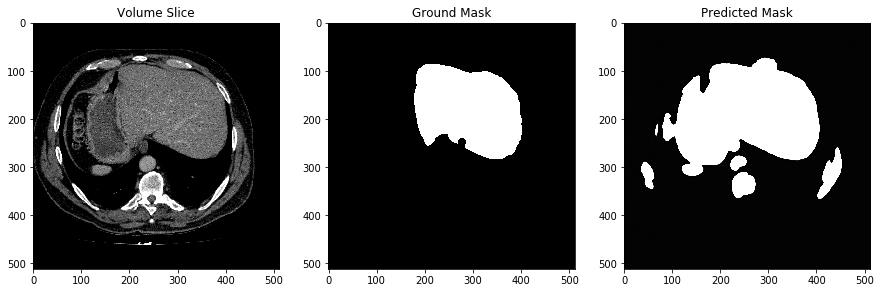

In [85]:
imshow(full_img_r[0].reshape(512,512),lbl.reshape(512,512),full_pred[0].reshape(512,512),title=['Volume Slice','Ground Mask','Predicted Mask'])


### Dice Calculation

In [87]:
from medpy import metric
print 'Dice coffecient:',metric.dc(reference=full_img_r,result=full_pred)

Dice coffecient: 0.586032061102
